### *Code modified from https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_model*
### *Modified by Soundpulse :D*

## TODO:

- Use Grid Search for better hyperparameters
- transform the predicted data back to the original axis
- Ensembling with other predicting architectures (Expotential Smoothing, Regression, KNN Regressor etc.)
- Extra: Dimensionality Reduction on the dataset? 🤔

In [1]:
import pandas as pd
import requests
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Data Science Accelerator Credentials 
RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" 
access_token = 'tUn7ZD2ZsW9jKiFpoS56ua2g3hnLaUEE8A1nE6cQ'

In [3]:
ric = 'JPY=' # put the RIC of the asset you want to retrieve data

requestData = {
    'interval': 'P1D',
    'start': '2016-11-01',
    'end': '2019-06-30',
    #"fields": 'TRDPRC_1' # Uncomment this line if you wish to specify which fields to be returned, e.g. TRDPRC_1 is an available field for AAPL.O
};

In [4]:
def get_data_request(url, requestData):
    """
    HTTP GET request to Refinitiv API
    
    There is more information in the returned dict (i.e. json) object from the API, we store the data in a DataFrame.
    
    :param url: str, the url of the API endpoint
    :param requestData: dict, contains user-defined variables
    :return: DataFrame, containing the historical pricing data. 
        Returned field list order and content can vary depending on the exchange / instrument.
        Therefore returned data must be treated using appropriate parsing techniques.
    """
    dResp = requests.get(url, headers = {'X-api-key': access_token}, params = requestData);       

    if dResp.status_code != 200:
        raise ValueError("Unable to get data. Code %s, Message: %s" % (dResp.status_code, dResp.text));
    else:
        print("Data access successful")
        jResp = json.loads(dResp.text);
        data = jResp[0]['data']
        headers = jResp[0]['headers']  
        names = [headers[x]['name'] for x in range(len(headers))]
        df = pd.DataFrame(data, columns=names )
        return df
    
resource_endpoint_ric = RESOURCE_ENDPOINT + ric  
df = get_data_request(resource_endpoint_ric, requestData)

Data access successful


In [5]:
print(df.shape)
df.head()

(694, 23)


,DATE,BID,ASK,BID_HIGH_1,BID_LOW_1,OPEN_BID,MID_PRICE,NUM_BIDS,ASK_LOW_1,ASK_HIGH_1,...,ASIACL_BID,EUROP_BID,EURHI_BID,EURLO_BID,EURCL_BID,AMEROP_BID,AMERHI_BID,AMERLO_BID,AMERCL_BID,OPEN_ASK
0,2019-06-28,107.88,107.91,107.93,107.55,107.78,107.895,91894.0,107.57,107.96,...,107.64,107.63,107.85,107.58,107.84,107.66,107.93,107.62,107.88,107.81
1,2019-06-27,107.78,107.81,108.15,107.63,107.78,107.795,94057.0,107.66,108.18,...,108.04,108.05,108.15,107.66,107.72,107.82,107.94,107.66,107.78,107.81
2,2019-06-26,107.77,107.80,107.84,107.08,107.18,107.785,81259.0,107.11,107.87,...,107.46,107.47,107.75,107.35,107.63,107.67,107.84,107.58,107.77,107.21
3,2019-06-25,107.17,107.20,107.40,106.77,107.29,107.185,98267.0,106.79,107.43,...,107.03,106.81,107.14,106.80,106.91,106.97,107.39,106.82,107.17,107.30
4,2019-06-24,107.28,107.31,107.53,107.23,107.39,107.295,86297.0,107.26,107.55,...,107.39,107.42,107.53,107.23,107.35,107.29,107.53,107.23,107.28,107.40


In [6]:
df['DATE'] = pd.to_datetime(df['DATE']).astype('O')
df.set_index('DATE', inplace=True)

df['dBid']= df.BID_HIGH_1 - df.BID_LOW_1
df['dAsk']= df.ASK_HIGH_1 - df.ASK_LOW_1
df['AMER_dBid']= df.AMERHI_BID - df.AMERLO_BID
df['ASIA_dBid']= df.ASIAHI_BID - df.ASIALO_BID
df['EUR_dBid']= df.EURHI_BID - df.EURLO_BID

df['OTC'] = df.AMERCL_BID.shift() - df.AMEROP_BID
df['AMER_OTC'] = df.AMERCL_BID.shift() - df.AMEROP_BID
df['ASIA_OTC'] = df.ASIACL_BID.shift() - df.ASIAOP_BID
df['EUR_OTC'] = df.EURCL_BID.shift() - df.EUROP_BID

df['AMER_FT'] = df.AMERCL_BID - df.AMEROP_BID
df['ASIA_FT'] = df.ASIACL_BID - df.ASIAOP_BID
df['EUR_FT'] = df.EURCL_BID - df.EUROP_BID


In [7]:
# 20 Cols
df = df.drop(columns=['AMEROP_BID', 'ASIAOP_BID', 'EUROP_BID', 'BID_HIGH_1', 'BID_LOW_1', 'ASK_HIGH_1', 'ASK_LOW_1'
          ,'AMERHI_BID','AMERLO_BID','ASIAHI_BID','ASIALO_BID','EURHI_BID','EURLO_BID','dAsk'])

# 6 Cols (Independent)
# df = df[['BID','AMER_dBid','AMER_OTC','AMER_FT','NUM_BIDS']]
df = df.bfill()
df.head(10)

,BID,ASK,OPEN_BID,MID_PRICE,NUM_BIDS,ASIACL_BID,EURCL_BID,AMERCL_BID,OPEN_ASK,dBid,AMER_dBid,ASIA_dBid,EUR_dBid,OTC,AMER_OTC,ASIA_OTC,EUR_OTC,AMER_FT,ASIA_FT,EUR_FT
DATE,,,,,,,,,,,,,,,,,,,,
2019-06-28,107.88,107.91,107.78,107.895,91894.0,107.64,107.84,107.88,107.81,0.38,0.31,0.28,0.27,0.06,0.06,-0.14,-0.21,0.22,-0.14,0.21
2019-06-27,107.78,107.81,107.78,107.795,94057.0,108.04,107.72,107.78,107.81,0.52,0.28,0.52,0.49,0.06,0.06,-0.14,-0.21,-0.04,0.26,-0.33
2019-06-26,107.77,107.80,107.18,107.785,81259.0,107.46,107.63,107.77,107.21,0.76,0.26,0.42,0.40,0.11,0.11,0.86,0.25,0.10,0.28,0.16
2019-06-25,107.17,107.20,107.29,107.185,98267.0,107.03,106.91,107.17,107.30,0.63,0.57,0.63,0.34,0.80,0.80,0.17,0.82,0.20,-0.26,0.10
2019-06-24,107.28,107.31,107.39,107.295,86297.0,107.39,107.35,107.28,107.40,0.30,0.30,0.22,0.30,-0.12,-0.12,-0.36,-0.51,-0.01,0.00,-0.07
2019-06-21,107.30,107.33,107.30,107.315,103704.0,107.45,107.54,107.30,107.33,0.69,0.44,0.48,0.68,-0.27,-0.27,0.09,0.26,-0.25,0.15,0.45
2019-06-20,107.29,107.32,108.08,107.305,104670.0,107.66,107.50,107.29,108.11,0.93,0.59,0.68,0.42,-0.47,-0.47,-0.63,-0.09,-0.48,-0.42,-0.13
2019-06-19,108.09,108.12,108.44,108.105,84189.0,108.37,108.36,108.09,108.47,0.72,0.60,0.39,0.27,-1.10,-1.10,-0.78,-0.84,-0.30,-0.07,0.02
2019-06-18,108.44,108.47,108.53,108.455,83698.0,108.24,108.39,108.44,108.56,0.62,0.62,0.38,0.62,-0.20,-0.20,-0.16,0.03,0.15,-0.29,0.06


In [8]:
# Warning: Performance Heavy!
plt.figure(figsize=(30,30))
#sns.pairplot(df)

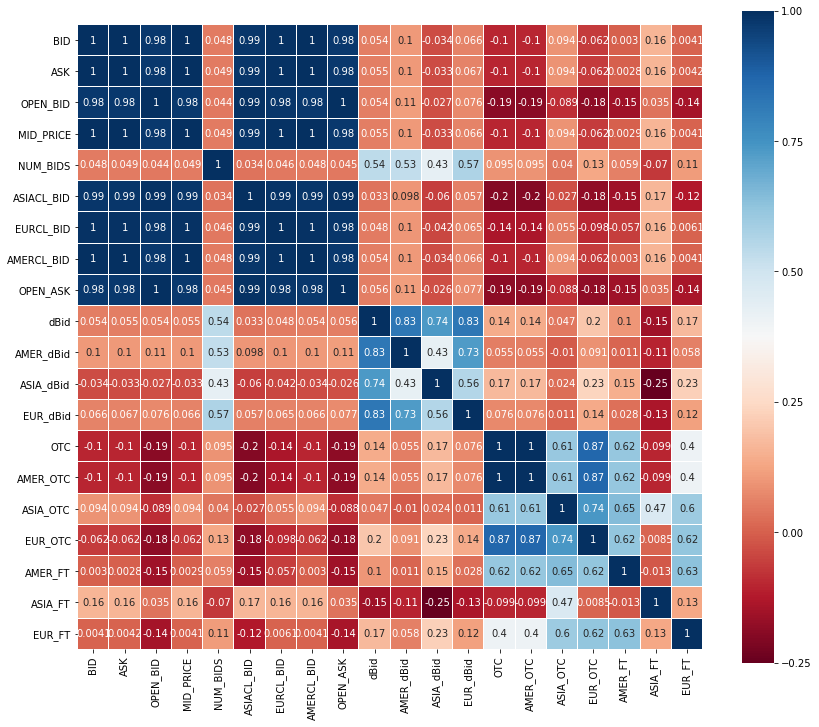

In [9]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
           square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

In [10]:
# Hyperparameters
# 50:25;25 Split
TRAIN_SPLIT=int(0.5*df.shape[0])

mu = df.mean()
sig = df.std()
dataset = (df-mu)/sig
dataset = dataset.values

In [11]:
# Functions

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)



def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps



def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()



def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Single window of past history : (80, 20)

 Target temperature to predict : (10,)


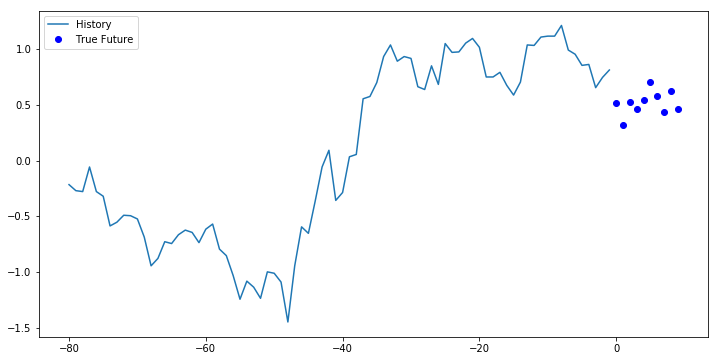

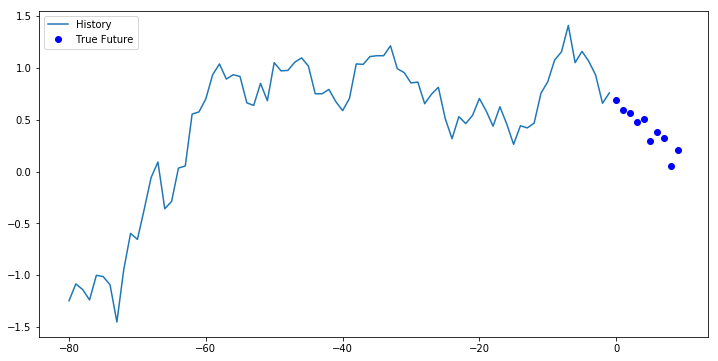

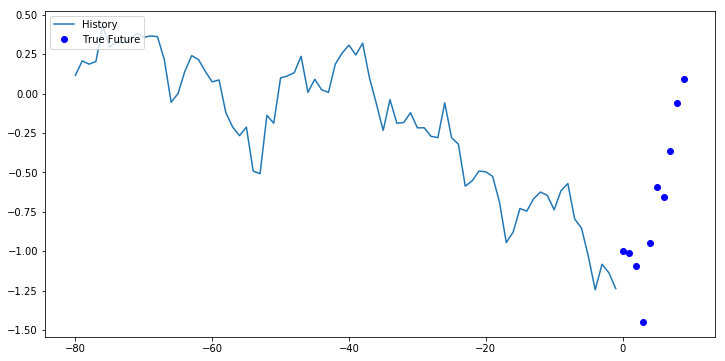

In [23]:
# Hyperparameters (TODO: Grid Search Tuning， Fix Underfitting)
# For multivariate_data function
past_history = 80
future_target = 10
STEP = 1
# For LSTM Model (Don't change this unless we have more data!)
BATCH_SIZE = 1
BUFFER_SIZE = 4096
# For fitting the model
EPOCHS=10
EVALUATION_INTERVAL=200
VALIDATION_STEPS=20
LSTM1_NODES = 32
LSTM2_NODES = 16

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# Generated Samples
for x, y in train_data_multi.take(3):
  multi_step_plot(x[0], y[0], np.array([0]))

In [18]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(LSTM1_NODES,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.LSTM(LSTM2_NODES, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')


In [19]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 20 steps
Epoch 1/10
200/200 [==============================] - 17s 83ms/step - loss: 0.6893 - val_loss: 0.4661
Epoch 2/10
200/200 [==============================] - 14s 69ms/step - loss: 0.2101 - val_loss: 0.7092
Epoch 3/10
200/200 [==============================] - 14s 68ms/step - loss: 0.1549 - val_loss: 1.0619
Epoch 4/10
200/200 [==============================] - 14s 68ms/step - loss: 0.1373 - val_loss: 0.6639
Epoch 5/10
200/200 [==============================] - 14s 68ms/step - loss: 0.1095 - val_loss: 0.5480
Epoch 6/10
200/200 [==============================] - 14s 68ms/step - loss: 0.0895 - val_loss: 0.8194
Epoch 7/10
200/200 [==============================] - 14s 69ms/step - loss: 0.0853 - val_loss: 0.7705
Epoch 8/10
200/200 [==============================] - 14s 68ms/step - loss: 0.0815 - val_loss: 0.9401
Epoch 9/10
200/200 [==============================] - 14s 68ms/step - loss: 0.0763 - val_loss: 0.8430
Epoch 10/10
200/200 [==================

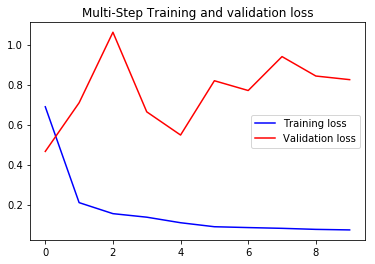

<TakeDataset shapes: ((None, 160, 20), (None, 36)), types: (tf.float64, tf.float64)>


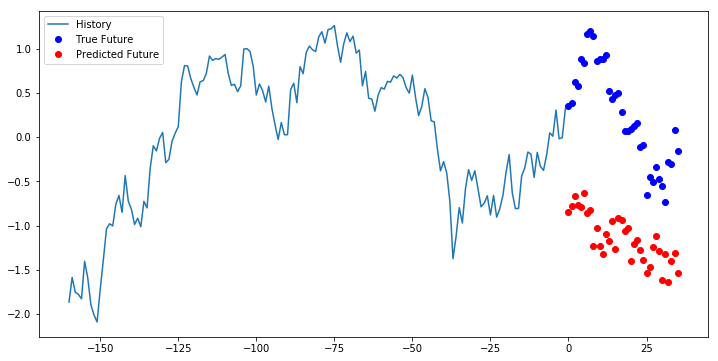

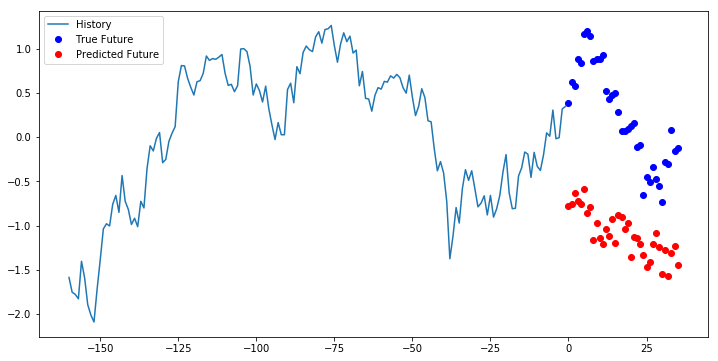

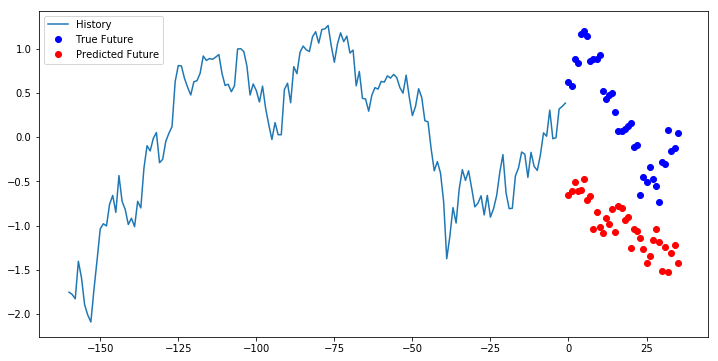

In [22]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

# Predicted Samples
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])